In [14]:
!nvidia-smi

Sat Sep 13 20:10:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050        Off |   00000000:03:00.0 Off |                  N/A |
| 37%   28C    P8             N/A /   75W |      10MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Сюда нужно будет написать настройку окружения

In [1]:
!uv sync
!cd ManiSkill && uv pip install -e . && cd ..
!cd SimplerEnv && uv pip install -e . && cd ..

Resolved 90 packages in 0.75ms
Uninstalled 37 packages in 87ms
Installed 1 package in 16ms                                 
 - absl-py==2.3.1
 - arm-pytorch-utilities==0.4.3
 - cloudpickle==3.1.1
 - dacite==1.9.2
 - docstring-parser==0.17.0
 - farama-notifications==0.0.4
 - fast-kinematics==0.2.2
 - gitdb==4.0.12
 - gitpython==3.1.45
 - gymnasium==0.29.1
 - h5py==3.14.0
 - imageio==2.37.0
 - imageio-ffmpeg==0.6.0
 - lxml==6.0.1
 - mani-skill==3.0.0b20 (from file:///home/jezv/Projects/RL4VLA/ManiSkill)
 - markdown-it-py==4.0.0
 - mdurl==0.1.2
 - mplib==0.1.1
 - numpy==1.26.4
 + numpy==2.2.6
 - nvidia-ml-py==13.580.82
 - opencv-python==4.11.0.86
 - pynvml==13.0.1
 - pyperclip==1.9.0
 - pytorch-kinematics==0.7.5
 - pytorch-seed==0.2.0
 - rich==14.1.0
 - sapien==3.0.0b1
 - scipy==1.15.3
 - shtab==1.7.2
 - simpler-env==0.0.1 (from file:///home/jezv/Projects/RL4VLA/SimplerEnv)
 - smmap==5.0.2
 - tabulate==0.9.0
 - toppra==0.6.3
 - transforms3d==0.4.2
 - trimesh==4.8.1
 - typeguard==4.4.4
 - 

In [2]:
!export CUDA_VISIBLE_DEVICES=1

In [3]:
from mani_skill.utils.registration import REGISTERED_ENVS

print(REGISTERED_ENVS.keys())

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/sapien/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


dict_keys(['SceneManipulation-v1', 'ArchitecTHOR_SceneManipulation-v1', 'ReplicaCAD_SceneManipulation-v1', 'ReplicaCADTidyHouseTrain_SceneManipulation-v1', 'ReplicaCADTidyHouseVal_SceneManipulation-v1', 'ReplicaCADPrepareGroceriesTrain_SceneManipulation-v1', 'ReplicaCADPrepareGroceriesVal_SceneManipulation-v1', 'ReplicaCADSetTableTrain_SceneManipulation-v1', 'ReplicaCADSetTableVal_SceneManipulation-v1', 'MS-CartpoleBalance-v1', 'MS-CartpoleSwingUp-v1', 'MS-HopperStand-v1', 'MS-HopperHop-v1', 'MS-HumanoidStand-v1', 'MS-HumanoidWalk-v1', 'MS-HumanoidRun-v1', 'MS-AntWalk-v1', 'MS-AntRun-v1', 'RotateValveLevel0-v1', 'RotateValveLevel1-v1', 'RotateValveLevel2-v1', 'RotateValveLevel3-v1', 'RotateValveLevel4-v1', 'RotateSingleObjectInHandLevel0-v1', 'RotateSingleObjectInHandLevel1-v1', 'RotateSingleObjectInHandLevel2-v1', 'RotateSingleObjectInHandLevel3-v1', 'PutCarrotOnPlateInScene-v1', 'PutEggplantInBasketScene-v1', 'StackGreenCubeOnYellowCubeBakedTexInScene-v1', 'PutSpoonOnTableClothInScen

In [4]:
tasks = ['PutCarrotOnPlateInScene-v1', 'PutOnPlateInScene25MultiCarrot-v1']

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForc

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


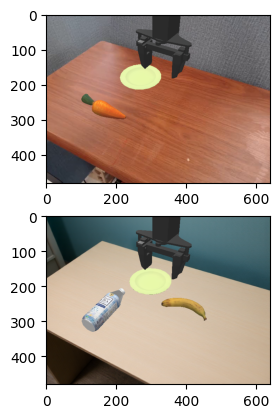

In [5]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

task_images = []

for i,task in enumerate(tasks):
    env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')
    # env.seed(42)
    
    obs, reset_info = env.reset(seed = 42)
    task_images.append(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
    plt.subplot(len(tasks), 1, i+1)
    plt.imshow(task_images[-1])


task_images = np.array(task_images)
plt.show()

In [6]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    ['I see a table, a plate, a carrot and a manipuletor.', 'I see a table, a plate, a banana, a bottle and a manipuletor.'],
    ['wood', 'Table made of something beige.'],
    ['There is a carrot and a plate on the table.', 'There is a banana, a bottle and a plate on the table'],
    ['I can eat a carrot.', 'I can eat a banana.'],
    ['A carrot', 'A bottle'],
    ['A carrot', 'A bottle']
]

In [7]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from bert_score import score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]
`torch_dtype` is deprecated! Use `dtype` instead!


In [9]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(answer[i])
        results = score(generated_texts, [answer[i]], lang='en')
        print(results)


User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Carrot and plate.
I see a table, a plate, a carrot and a manipuletor.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7479]), tensor([0.8471]), tensor([0.7944]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Bottle, plate, banana, and a microscope.
I see a table, a plate, a banana, a bottle and a manipuletor.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7475]), tensor([0.8969]), tensor([0.8154]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is the table made of?
Assistant: Wood.
Table made of wood.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7079]), tensor([0.9137]), tensor([0.7977]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is the table made of?
Assistant: Wood.
Table made of something beige.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7108]), tensor([0.8661]), tensor([0.7808]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is on the table?
Assistant: Carrot and plate.
There is a carrot and a plate on the table.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7289]), tensor([0.9019]), tensor([0.8062]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is on the table?
Assistant: Bottle, plate, and bananas
There is a banana, a bottle and a plate on the table


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7361]), tensor([0.9016]), tensor([0.8105]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What can you eat on the table?
Assistant: Carrot.
I can eat a carrot.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7149]), tensor([0.9009]), tensor([0.7972]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What can you eat on the table?
Assistant: Banana.
I can eat a banana.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7141]), tensor([0.8979]), tensor([0.7955]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is closest to the edge of the table?
Assistant: Carrot.
A carrot


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6938]), tensor([0.8814]), tensor([0.7764]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is closest to the edge of the table?
Assistant: Bottle.
A bootle


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6935]), tensor([0.8148]), tensor([0.7493]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is most likely to fall off a table?
Assistant: Carrot.
A carrot


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6911]), tensor([0.8765]), tensor([0.7728]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is most likely to fall off a table?
Assistant: Banana.
A bootle


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6887]), tensor([0.8022]), tensor([0.7412]))


In [ ]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

        messages += [
            {
                "role": "assistant",
                "content": [
                    {"type": "text", 'text': generated_texts[0]}
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", 'text': f"Right answer was: {answer[i]}. Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]"}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(generated_texts[0].split('\n')[-1])

Assistant: Carrot and plate.
I see a table, a plate, a carrot and a manipuletor.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Carrot and plate.
User: Right answer was: I see a table, a plate, a carrot and a manipuletor..Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]
Assistant: No.
Assistant: No.
Assistant: Bottle, plate, banana, and a microscope.
I see a table, a plate, a banana, a bottle and a manipuletor.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><r

In [13]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    [('table', 'plate', 'carrot', 'manipulator'), ('table', 'plate', 'banana', 'bottle', 'manipulator')],
    [('wood'), ('wood')],
    [('carrot', 'plate'), ('banana', 'bottle', 'plate')],
    [('carrot'), ('banana')],
    [('carrot'), ('bottle')],
    [('carrot'), ('bottle')]
]

In [17]:
corrects = 0

for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        correct = True
        for keyword in answer[i]:
            correct &= keyword in generated_texts[0].split('\n')[-1].lower()
        if correct: corrects += 1

        print(correct)
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

SR = corrects / (len(task_questions)*len(task_images))
print('='*30)
print(f'{SR*100:.2f}%')

False
Assistant: Carrot and plate.
('table', 'plate', 'carrot', 'manipulator')
False
Assistant: Bottle, plate, banana, and a microscope.
('table', 'plate', 'banana', 'bottle', 'manipulator')
True
Assistant: Wood.
wood
True
Assistant: Wood.
wood
True
Assistant: Carrot and plate.
('carrot', 'plate')
True
Assistant: Bottle, plate, and bananas
('banana', 'bottle', 'plate')
True
Assistant: Carrot.
carrot
True
Assistant: Banana.
banana
True
Assistant: Carrot.
carrot
True
Assistant: Bottle.
bottle
True
Assistant: Carrot.
carrot
False
Assistant: Banana.
bottle
75.00%
